# Shallow Dive

These experiments are on the k-epsilon controllability of the top 75 tokens of 
25 unique Wikitext sequences. 

We will leverage much of the same code from the [Deep Dive]() experiments: 

## Generating the Datasets

We want to get this done over night for a preliminary view tomorrow morning. So 
let's select 25 unique starting states $x_0$ and make a dataset where the desired 
tokens $y^*$ for each $x_0$ are the top 75 tokens in terms of $P(y* | x_0)$. 

```bash 
>>> python3 scripts/generate_deep_dive.py \
    --input_file results/wiki_reachability/k10_falcon7b_wiki5k.csv \
    --output_file results/shallow_dive/falcon7b_top75_states25_1875.csv \
    --model falcon-7b \
    --skip -1 \
    --num_unique_states 25 \
    --num_shallow 75 
```


```bash
>>> python3 scripts/generate_deep_dive.py \
    --input_file results/wiki_reachability/k10_llama_7b_wiki5k.csv \
    --output_file results/shallow_dive/llama7b_top75_states25_1875.csv \
    --model llama-7b \
    --skip -1 \
    --num_unique_states 25 \
    --num_shallow 75 
```


```bash
>>> python3 scripts/generate_deep_dive.py \
    --input_file results/wiki_reachability/k10_falcon7b_wiki5k.csv \
    --output_file results/shallow_dive/falcon40b_top75_states10_750.csv \
    --model falcon-40b \
    --skip -1 \
    --num_unique_states 10 \
    --num_shallow 75

>>> python3 scripts/generate_deep_dive.py \
    --input_file results/wiki_reachability/k10_falcon7b_wiki5k.csv \
    --output_file results/shallow_dive/falcon40b_top75_states7_525.csv \
    --model falcon-40b \
    --skip -1 \
    --num_unique_states 7 \
    --num_shallow 75
```


## Falcon Reachability Experiments

Now we can run the `scripts/reachability.py` script on this dataset. I'll make a 
`falcon_shallowdive.sh` script so we can run it with the same convention as 
usual. 

```bash
CUDA_VISIBLE_DEVICES=0 bash scripts/shallow_dive_falcon7b.sh 0 8  # ran at ~4:30a on Sat Nov 18
CUDA_VISIBLE_DEVICES=1 bash scripts/shallow_dive_falcon7b.sh 1 8
CUDA_VISIBLE_DEVICES=2 bash scripts/shallow_dive_falcon7b.sh 2 8
CUDA_VISIBLE_DEVICES=3 bash scripts/shallow_dive_falcon7b.sh 3 8


CUDA_VISIBLE_DEVICES=0 bash scripts/shallow_dive_falcon7b.sh 4 8  # ran at ~4:30a on Sat Nov 18
CUDA_VISIBLE_DEVICES=1 bash scripts/shallow_dive_falcon7b.sh 5 8
CUDA_VISIBLE_DEVICES=2 bash scripts/shallow_dive_falcon7b.sh 6 8
CUDA_VISIBLE_DEVICES=3 bash scripts/shallow_dive_falcon7b.sh 7 8
```

## Llama Reachability Experiments


_Ran on Sun Nov 19 at ~9p_
```bash
# Superheavy 1
CUDA_VISIBLE_DEVICES=0 bash scripts/shallow_dive_llama7b.sh 0 16  
CUDA_VISIBLE_DEVICES=1 bash scripts/shallow_dive_llama7b.sh 1 16
CUDA_VISIBLE_DEVICES=2 bash scripts/shallow_dive_llama7b.sh 2 16
CUDA_VISIBLE_DEVICES=3 bash scripts/shallow_dive_llama7b.sh 3 16    

# Oracle Colossus
CUDA_VISIBLE_DEVICES=0 bash scripts/shallow_dive_llama7b.sh 4 16
CUDA_VISIBLE_DEVICES=1 bash scripts/shallow_dive_llama7b.sh 5 16
CUDA_VISIBLE_DEVICES=2 bash scripts/shallow_dive_llama7b.sh 6 16
CUDA_VISIBLE_DEVICES=3 bash scripts/shallow_dive_llama7b.sh 7 16

CUDA_VISIBLE_DEVICES=4 bash scripts/shallow_dive_llama7b.sh 8 16
CUDA_VISIBLE_DEVICES=5 bash scripts/shallow_dive_llama7b.sh 9 16
CUDA_VISIBLE_DEVICES=6 bash scripts/shallow_dive_llama7b.sh 10 16
CUDA_VISIBLE_DEVICES=7 bash scripts/shallow_dive_llama7b.sh 11 16

# Superheavy 3
CUDA_VISIBLE_DEVICES=0 bash scripts/shallow_dive_llama7b.sh 12 16  
CUDA_VISIBLE_DEVICES=1 bash scripts/shallow_dive_llama7b.sh 13 16
CUDA_VISIBLE_DEVICES=2 bash scripts/shallow_dive_llama7b.sh 14 16
CUDA_VISIBLE_DEVICES=3 bash scripts/shallow_dive_llama7b.sh 15 16    
```


## Falcon-40b Reachability 
```bash
bash scripts/shallow_dive_falcon40b.sh 0 4 # launched 8a Nov 20 
bash scripts/shallow_dive_falcon40b.sh 1 4 # launched 8a Nov 20 
CUDA_VISIBLE_DEVICE=0,1,2,3 bash scripts/shallow_dive_falcon40b.sh 2 4 # launched 8a Nov 20
CUDA_VISIBLE_DEVICE=4,5,6,7 bash scripts/shallow_dive_falcon40b.sh 3 4 # launched 8a Nov 20 
```

**Failed worker 2**: 
We will run worker 2's load on the 3 workers simultaneously as: 
```bash
# oracle 1
CUDA_VISIBLE_DEVICES=0,1,2,3 bash scripts/shallow_dive_falcon40b.sh 2 16
# oracle 2 
CUDA_VISIBLE_DEVICES=4,5,6,7 bash scripts/shallow_dive_falcon40b.sh 6 16
# superheavy 1 
bash scripts/shallow_dive_falcon40b.sh 10 16
# superheavy 2
bash scripts/shallow_dive_falcon40b.sh 14 16

```

In [1]:
# Import box 
import pandas as pd 
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

In [2]:
# Constants for plotting 
FIG_SIZE = (8, 6)

## 0: Global Plotting Functions

In [3]:
def add_zero_prompt_length(df_in): 
    # set prompt_length to zero when base_correct is true 
    df_in.loc[df_in['base_correct'] == True, 'prompt_length'] = 0
    return df_in
def overview_report(df_in): 
    print("Length of dataframe: ", len(df_in))
    print("Mean prompt correct (epsilon): \t", df_in['prompt_correct'].mean())
    print("Mean prompt correct with k <= 4: ", len(df_in[df_in['prompt_length'] <= 4]) / len(df_in))
    print("Mean base correct: \t\t", df_in['base_correct'].mean())
    print("Mean prompt length: \t\t", df_in['prompt_length'].mean())


In [4]:
def k_epsilon_line_plot(df_in,
                        title="TITLE",
                        output_path=None, 
                        figsize=(6, 4), 
                        log_y=False): 
    # Placeholder for the final percentages
    results = []

    # For each unique question_length
    question_lengths = df_in['question_length'].unique().tolist()
    question_lengths.sort()
    for q_len in question_lengths:
        # Filter the dataframe
        temp_df = df_in[df_in['question_length'] == q_len]

        percentage_correct = []
        prompt_lengths = sorted(temp_df['prompt_length'].unique())
        prompt_lengths = [0] + prompt_lengths
        for p_len in prompt_lengths:
            # Calculate the percentage for this prompt_length
            portion = temp_df[temp_df['prompt_length'] <= p_len]
            correct = portion['prompt_correct'].sum()
            total = len(temp_df)
            percentage = 1-(correct/total)
            percentage_correct.append((p_len, percentage))

        results.append((q_len, percentage_correct))

    # Plotting
    plt.figure(figsize=figsize)

    for q_len, percentages in results:
        x, y = zip(*percentages)
        y = np.array(y)
        plt.plot(x, y, label=f'|x_0| = {q_len}')

    plt.xlabel('Prompt Length [k]')

    
    
    # logarithmic y-axis 
    if log_y: 
        plt.yscale('log')
        plt.ylabel('Log(Portion Incorrect) [log(ϵ)]')
    else:
        plt.ylabel('Portion Incorrect [ϵ]')

    plt.title(title)
    plt.legend()
    plt.grid(True)
    # plt.yscale('log')
    if output_path is not None:
        plt.savefig(output_path, dpi=300)
    return results


In [5]:
def loss_k_correlation_plots(df_in, 
                             suptitle="TITLE", 
                             output_path=None, 
                             figsize=(8, 9)):
    solved_df = df_in[df_in['prompt_correct'] == 1]
    question_lengths = solved_df['question_length'].unique().tolist()
    question_lengths.sort()

    # make a 3 by 2 grid of plots
    fig, axs = plt.subplots(3, 2, figsize=figsize, sharex=True, sharey=True)
    # sharex and sharey
    print(question_lengths)
    # plot a scatter plot of base_correct vs. prompt_length
    for idx_, q_len in enumerate(question_lengths):
        # Filter the dataframe
        temp_df = df_in[df_in['question_length'] == q_len]
        idx = idx_ + 1
        axs[idx//2, idx%2].scatter(temp_df['base_loss'], temp_df['prompt_length'], alpha=0.5)
        axs[idx//2, idx%2].set_xlabel('Base Loss')
        axs[idx//2, idx%2].set_ylabel('Prompt Length [k]')

        # compute the Pearson correlation coefficient between base_loss and prompt_length
        corr = temp_df['base_loss'].corr(temp_df['prompt_length'])
        print(f'Pearson correlation coefficient (q_len={q_len}): {corr}')
        axs[idx//2, idx%2].set_title(f'Question Len {q_len}: Corr={corr:.2f}')

    # Now we add the overall plot in axs[0,0] 
    axs[0,0].scatter(solved_df['base_loss'], solved_df['prompt_length'], alpha=0.5, c='r')    
    axs[0,0].set_xlabel('Base Loss')
    axs[0,0].set_ylabel('Prompt Length [k]')
    corr = solved_df['base_loss'].corr(solved_df['prompt_length'])
    axs[0,0].set_title(f'All Question Lengths -- Corr={corr:.2f}')
    corr = solved_df['base_loss'].corr(solved_df['prompt_length'])

    # tight layout
    plt.suptitle(suptitle)
    plt.tight_layout()

    if output_path is not None:
        plt.savefig(output_path, dpi=300)
    

### 0.1: New Plotting Functions

Home-cooked plotting funtions for understanding the shallow dive stuff. 

In [6]:
def base_rank_k_scatter(ranked_shallow1_df, 
                        title="TITLE",
                        output_path=None,
                        figsize=(8, 6)):

    # First we separate the solved instances from the unsolved ones so we can color 
    # them differently. 
    solved_df= ranked_shallow1_df[ranked_shallow1_df['prompt_correct'] == 1]
    unsolved_df = ranked_shallow1_df[ranked_shallow1_df['prompt_correct'] == 0]

    assert len(solved_df) + len(unsolved_df) == len(ranked_shallow1_df)
    print("Unsolved prompt lengths (10): ", unsolved_df['prompt_length'].unique())

    # now we add 2 to the unsolved dataframes' prompt length values so that it sticks 
    # out from the solved ones.
    # unsolved_df['prompt_length'] = unsolved_df['prompt_length'] + 2
    unsolved_df.loc[:, 'prompt_length'] += 2

    print("Unsolved prompt lengths (12): ", unsolved_df['prompt_length'].unique())


    # Now for the figure. 
    plt.figure(figsize=figsize)

    # plot the solved instances
    plt.scatter(solved_df['base_rank'], 
                solved_df['prompt_length'], 
                alpha=0.1, 
                label='solved')
    plt.scatter(unsolved_df['base_rank'], 
                unsolved_df['prompt_length'], 
                alpha=0.1, 
                label='unsolved')


    # let's also set the y-tick at 12 to say 'UNSOLVED' instead of 12
    # Getting current y-ticks
    current_ticks = plt.yticks()[0]

    # Adding the custom tick for 'unsolved' or infinity
    new_ticks = np.arange(0, 14, 2)
    new_tick_labels = list(new_ticks) 
    new_tick_labels[-1] = 'unreached'

    # Setting the new ticks and labels
    plt.yticks(new_ticks, new_tick_labels)



    # let's compute the correlation coefficient between base_rank and prompt_length
    corr = ranked_shallow1_df['base_rank'].corr(ranked_shallow1_df['prompt_length'])
    print(f'Pearson correlation coefficient: {corr}')

    plt.legend()

    # add x and y axis labels
    plt.xlabel('Base Rank of P(y* | x_0)')
    plt.ylabel('Prompt Length [k]')

    # title 
    plt.title(title)


    # save the figure
    if output_path is not None:
        print("Saving figure...")
        plt.savefig(output_path, dpi=300)
        print("Done")

In [7]:
def base_loss_vs_prompt_len(ranked_shallow1_df, 
                            title="TITLE",
                            output_path=None,
                            figsize=(8, 6)):
    
    # Let's plot base loss vs. prompt length 
    solved_df= ranked_shallow1_df[ranked_shallow1_df['prompt_correct'] == 1]
    unsolved_df = ranked_shallow1_df[ranked_shallow1_df['prompt_correct'] == 0]

    # add 1 to the unsolved dataframes' prompt length values so that it sticks
    # out from the solved ones.
    unsolved_df.loc[:, 'prompt_length'] += 2


    # figure 
    plt.figure(figsize=figsize)

    # scatter plotting
    plt.scatter(solved_df['base_loss'], solved_df['prompt_length'], alpha=0.1, label='solved')
    plt.scatter(unsolved_df['base_loss'], unsolved_df['prompt_length'], alpha=0.1, label='unsolved')

    # Update y ticks
    current_ticks = plt.yticks()[0]
    new_ticks = np.arange(0, 14, 2)
    new_tick_labels = list(new_ticks)
    new_tick_labels[-1] = 'unreached'
    plt.yticks(new_ticks, new_tick_labels)


    # x and y axis labels
    plt.xlabel('Base Loss on P(y* | x_0)')
    plt.ylabel('Prompt Length [k]')


    # let's compute the correlation coefficient between base_rank and prompt_length
    corr = ranked_shallow1_df['base_loss'].corr(ranked_shallow1_df['prompt_length'])
    print(f'Pearson correlation coefficient: {corr}')

    plt.legend()

    # title 
    plt.title(title)

    # save fig 
    if output_path is not None:
        print("Saving figure...")
        plt.savefig(output_path, dpi=300)
        print("Done")
    plt.show()


In [30]:
# Just for fun -- let's try plotting base rank vs. base loss 
def base_rank_vs_base_loss(ranked_shallow1_df, 
                           title="TITLE",
                           output_path=None,
                           figsize=(8, 6)):
    # Let's plot base loss vs. prompt length 
    solved_df= ranked_shallow1_df[ranked_shallow1_df['prompt_correct'] == 1]
    unsolved_df = ranked_shallow1_df[ranked_shallow1_df['prompt_correct'] == 0]

    # add 1 to the unsolved dataframes' prompt length values so that it sticks
    # out from the solved ones.
    unsolved_df.loc[:, 'prompt_length'] += 2


    # figure 
    plt.figure(figsize=figsize)

    # scatter plotting
    plt.scatter(solved_df['base_rank'], solved_df['base_loss'], alpha=0.1, label='solved')
    plt.scatter(unsolved_df['base_rank'], unsolved_df['base_loss'], alpha=0.1, label='unsolved')

    # x and y axis labels
    plt.xlabel('Base Rank on P(y* | x_0)')
    plt.ylabel('Base Loss on P(y* | x_0)')

    # let's compute the correlation coefficient between base_rank and prompt_length
    corr = ranked_shallow1_df['base_rank'].corr(ranked_shallow1_df['base_loss'])
    print(f'Pearson correlation coefficient: {corr}')

    plt.legend()

    # title 
    plt.title(title)

    # save fig 
    if output_path is not None:
        print("Saving figure...")
        plt.savefig(output_path, dpi=300)
        print("Done")
    plt.show()

# 1: Falcon-7b Top-75 Experiments 

## 1.1: Retrieve Data

In [8]:
file_path = f'falcon-7b/shallow1_*_of_8.csv'
file_list = glob.glob(file_path)
print(file_list)
df_list = []
for file in file_list:
    df_list.append(pd.read_csv(file))
shallow_df = pd.concat(df_list)
shallow_df.head()

['falcon-7b/shallow1_1_of_8.csv', 'falcon-7b/shallow1_4_of_8.csv', 'falcon-7b/shallow1_5_of_8.csv', 'falcon-7b/shallow1_0_of_8.csv', 'falcon-7b/shallow1_3_of_8.csv', 'falcon-7b/shallow1_6_of_8.csv', 'falcon-7b/shallow1_2_of_8.csv', 'falcon-7b/shallow1_7_of_8.csv']


,question,question_ids,answer,answer_ids,base_loss,search_method,best_prompt,best_prompt_ids,prompt_length,prompted_loss,base_correct,prompt_correct,question_length
0,"following his debut album, but received","[1863, 545, 9654, 5026, 204, 23, 480, 3245]",mixed,7697,1.960938,greedy,refreshing,[17423],1,0.953125,False,True,8
1,"following his debut album, but received","[1863, 545, 9654, 5026, 204, 23, 480, 3245]",very,829,3.937500,gcg,tits,"[34476, 27903, 26373, 39, 44957, 62530, 877, 5...",8,0.597656,False,True,8
2,"following his debut album, but received","[1863, 545, 9654, 5026, 204, 23, 480, 3245]",generally,4701,4.437500,greedy,SDK,"[35266, 8217, 11982]",3,1.500000,False,True,8
3,"following his debut album, but received","[1863, 545, 9654, 5026, 204, 23, 480, 3245]",its,701,5.187500,greedy,réalisé,"[64227, 27258]",2,1.781250,False,True,8
4,"following his debut album, but received","[1863, 545, 9654, 5026, 204, 23, 480, 3245]",almost,2376,5.531250,gcg,Larry,"[44159, 31495, 58427, 24286, 61903, 27094, 570...",10,3.578125,False,False,8


In [9]:
# Save the dataframe to a csv file 
output_path = 'falcon-7b/shallow1.csv'
# check if it exists
if os.path.exists(output_path):
    print("File already exists")
else: 
    print(f"Saving dive1 to {output_path}")
    shallow_df.to_csv(output_path, index=False, lineterminator='\n')

File already exists


In [10]:
# overview
overview_report(shallow_df)

Length of dataframe:  1875
Mean prompt correct (epsilon): 	 0.8938666666666667
Mean prompt correct with k <= 4:  0.5498666666666666
Mean base correct: 		 0.013333333333333334
Mean prompt length: 		 5.049066666666667


Let's now create a version of the `dive1.csv` dataset with the logits and 
rankings: 
```bash
>>> python3 scripts/add_logits.py \
    --input_file results/shallow_dive/falcon-7b/shallow1.csv \
    --output_file results/shallow_dive/falcon-7b/ranked_shallow1.csv \
    --model falcon-7b
```

Now we can load in the ranked csv from `falcon-7b/ranked_shallow1.csv`

In [11]:
try: 
    ranked_shallow1_df = pd.read_csv('falcon-7b/ranked_shallow1.csv', lineterminator='\n')
except: 
    # throw error that the file does not exist
    print("File `falcon-7b/ranked_shallow1.csv` does not exist. Please run `add_logits.py` script.")
overview_report(ranked_shallow1_df)

Length of dataframe:  1875
Mean prompt correct (epsilon): 	 0.8938666666666667
Mean prompt correct with k <= 4:  0.5498666666666666
Mean base correct: 		 0.013333333333333334
Mean prompt length: 		 5.049066666666667


## 1.2: Falcon Plots

Let's begin with a generic $k-\epsilon$ plot for the shallow dive on the top 75 tokens. 

[(8,
  [(0, 0.9866666666666667),
   (0, 0.9866666666666667),
   (1, 0.8773333333333333),
   (2, 0.64),
   (3, 0.5066666666666666),
   (4, 0.368),
   (6, 0.21866666666666668),
   (8, 0.128),
   (10, 0.06666666666666665)]),
 (10,
  [(0, 0.9866666666666667),
   (0, 0.9866666666666667),
   (1, 0.88),
   (2, 0.6693333333333333),
   (3, 0.504),
   (4, 0.3413333333333334),
   (6, 0.20799999999999996),
   (8, 0.13866666666666672),
   (10, 0.08799999999999997)]),
 (16,
  [(0, 0.9866666666666667),
   (0, 0.9866666666666667),
   (1, 0.904),
   (2, 0.7813333333333333),
   (3, 0.656),
   (4, 0.3733333333333333),
   (6, 0.14400000000000002),
   (8, 0.053333333333333344),
   (10, 0.01866666666666672)]),
 (22,
  [(0, 0.9866666666666667),
   (0, 0.9866666666666667),
   (1, 0.912),
   (2, 0.7413333333333334),
   (3, 0.656),
   (4, 0.5493333333333333),
   (6, 0.36),
   (8, 0.2533333333333333),
   (10, 0.17333333333333334)]),
 (32,
  [(0, 0.9866666666666667),
   (0, 0.9866666666666667),
   (1, 0.965333333

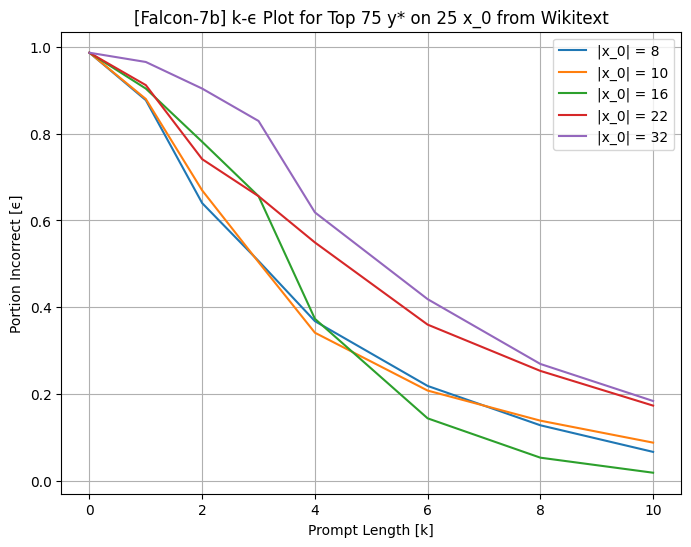

In [12]:
# K-epsilon plot across all questions
k_epsilon_line_plot(ranked_shallow1_df, 
                    title='[Falcon-7b] k-ϵ Plot for Top 75 y* on 25 x_0 from Wikitext', 
                    output_path='../figures/shallow1_falcon7b_k_epsilon.pdf', 
                    figsize=FIG_SIZE, 
                    log_y=False)

Now we will plot the base rank of each $y^*$ in the top 75 versus the number of prompt tokens $k$ required to achieve success. 

Note that we want to place the unsolved instances above 10 -- maybe at 12, then 
rename the y-axis tick at 12 to be `[Unsolved]` or something. 

Unsolved prompt lengths (10):  [10]
Unsolved prompt lengths (12):  [12]
Pearson correlation coefficient: 0.26683591917596494
Saving figure...
Done


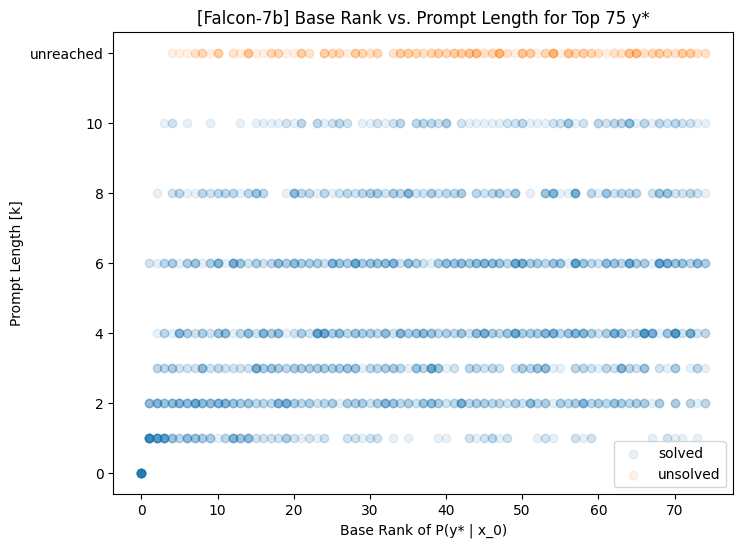

In [13]:
title = '[Falcon-7b] Base Rank vs. Prompt Length for Top 75 y*'
output_path = '../figures/shallow1_falcon7b_base_rank_vs_prompt_length.pdf'
base_rank_k_scatter(ranked_shallow1_df, 
                    title=title, 
                    output_path=output_path, 
                    figsize=FIG_SIZE)

Pearson correlation coefficient: 0.422273917694776
Saving figure...
Done


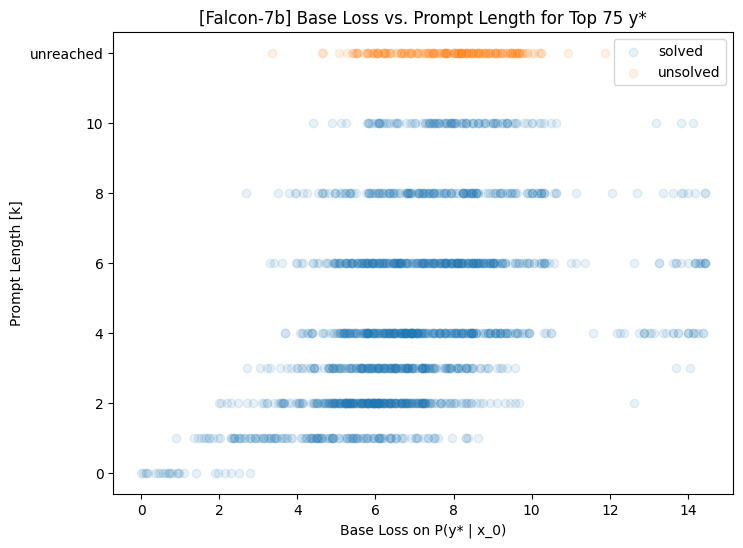

In [14]:
# Let's take a look at base loss vs. prompt length 
title = '[Falcon-7b] Base Loss vs. Prompt Length for Top 75 y*'
output_path = '../figures/shallow1_falcon7b_base_loss_vs_prompt_length.pdf'
base_loss_vs_prompt_len(ranked_shallow1_df, 
                        title=title, 
                        output_path=output_path, 
                        figsize=FIG_SIZE)


Pearson correlation coefficient: 0.5541080753085746
Saving figure...
Done


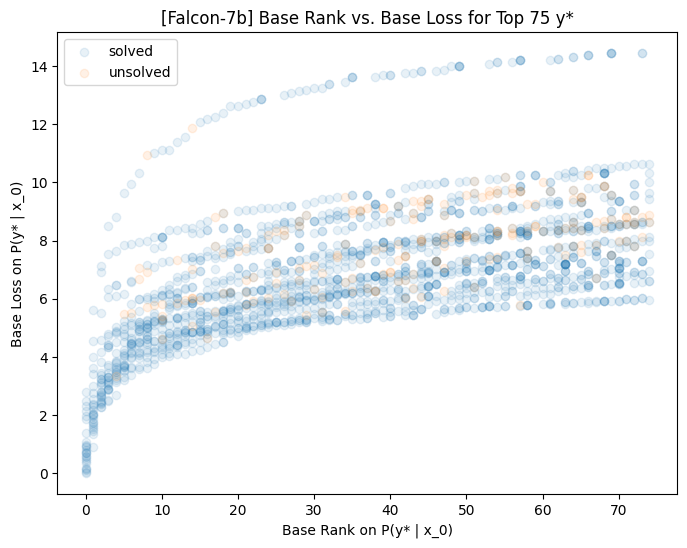

In [20]:
title = '[Falcon-7b] Base Rank vs. Base Loss for Top 75 y*'
output_path = '../figures/shallow1_falcon7b_base_rank_vs_base_loss.pdf'
base_rank_vs_base_loss(ranked_shallow1_df, 
                       title=title, 
                       output_path=output_path, 
                       figsize=FIG_SIZE)

## 2: Llama-7b Top-75 Experiments

### 2.1: Load the Llama-7b Data

In [22]:
file_path = f'llama-7b/shallow1_*_of_16.csv' 
file_list = glob.glob(file_path)
print(file_list)
df_list = []
for file in file_list:
    df_list.append(pd.read_csv(file, lineterminator='\n'))
shallow_df = pd.concat(df_list)

print("Length of df: ", len(shallow_df))
# shallow_df.head()

['llama-7b/shallow1_8_of_16.csv', 'llama-7b/shallow1_10_of_16.csv', 'llama-7b/shallow1_13_of_16.csv', 'llama-7b/shallow1_0_of_16.csv', 'llama-7b/shallow1_15_of_16.csv', 'llama-7b/shallow1_1_of_16.csv', 'llama-7b/shallow1_14_of_16.csv', 'llama-7b/shallow1_9_of_16.csv', 'llama-7b/shallow1_3_of_16.csv', 'llama-7b/shallow1_11_of_16.csv', 'llama-7b/shallow1_6_of_16.csv', 'llama-7b/shallow1_5_of_16.csv', 'llama-7b/shallow1_4_of_16.csv', 'llama-7b/shallow1_12_of_16.csv', 'llama-7b/shallow1_2_of_16.csv', 'llama-7b/shallow1_7_of_16.csv']
Length of df:  1875


In [23]:
# Save the dataframe to a csv file 
output_path = 'llama-7b/shallow1.csv'
# check if it exists
if os.path.exists(output_path):
    print("File already exists")
else:
    print(f"Saving dive1 to {output_path}")
    shallow_df.to_csv(output_path, index=False, lineterminator='\n')
    

File already exists


In [25]:
# overview
overview_report(shallow_df)

Length of dataframe:  1875
Mean prompt correct (epsilon): 	 0.8549333333333333
Mean prompt correct with k <= 4:  0.56
Mean base correct: 		 0.013333333333333334
Mean prompt length: 		 5.058133333333333


Let's now create a version of the `dive1.csv` dataset with the logits and 
rankings: 
```bash
>>> python3 scripts/add_logits.py \
    --input_file results/shallow_dive/llama-7b/shallow1.csv \
    --output_file results/shallow_dive/llama-7b/ranked_shallow1.csv \
    --model llama-7b
```

Now we can load in the ranked csv from `falcon-7b/ranked_shallow1.csv`

In [26]:
# Load in the ranked shallow df 
try: 
    ranked_shallow1_df = pd.read_csv('llama-7b/ranked_shallow1.csv', lineterminator='\n')
except:
    # throw error that the file does not exist
    print("File `llama-7b/ranked_shallow1.csv` does not exist. Please run `add_logits.py` script.")
overview_report(ranked_shallow1_df)

Length of dataframe:  1875
Mean prompt correct (epsilon): 	 0.8549333333333333
Mean prompt correct with k <= 4:  0.56
Mean base correct: 		 0.013333333333333334
Mean prompt length: 		 5.058133333333333


### 2.2: Llama-7b Plots

[(8,
  [(0, 0.9866666666666667),
   (0, 0.9866666666666667),
   (1, 0.6986666666666667),
   (2, 0.368),
   (3, 0.264),
   (4, 0.058666666666666645),
   (6, 0.026666666666666616),
   (8, 0.013333333333333308),
   (10, 0.005333333333333301)]),
 (10,
  [(0, 0.9866666666666667),
   (0, 0.9866666666666667),
   (1, 0.8133333333333334),
   (2, 0.5680000000000001),
   (3, 0.4826666666666667),
   (4, 0.29333333333333333),
   (6, 0.18400000000000005),
   (8, 0.1253333333333333),
   (10, 0.08799999999999997)]),
 (16,
  [(0, 0.9866666666666667),
   (0, 0.9866666666666667),
   (1, 0.7626666666666666),
   (2, 0.616),
   (3, 0.5653333333333334),
   (4, 0.472),
   (6, 0.3573333333333333),
   (8, 0.23199999999999998),
   (10, 0.1306666666666667)]),
 (22,
  [(0, 0.9866666666666667),
   (0, 0.9866666666666667),
   (1, 0.9546666666666667),
   (2, 0.896),
   (3, 0.8506666666666667),
   (4, 0.6266666666666667),
   (6, 0.4613333333333334),
   (8, 0.30666666666666664),
   (10, 0.19466666666666665)]),
 (32,
  

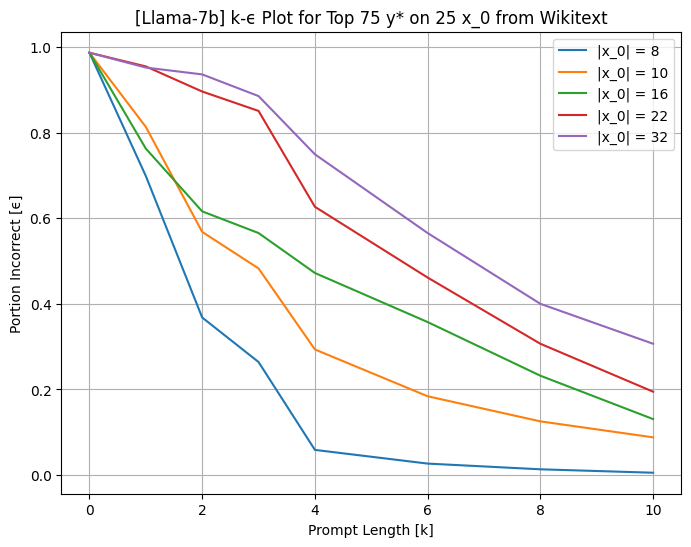

In [27]:
# let's start with a k-epsilon line plot 
title = '[Llama-7b] k-ϵ Plot for Top 75 y* on 25 x_0 from Wikitext'
output_path = '../figures/shallow1_llama7b_k_epsilon.pdf'
k_epsilon_line_plot(shallow_df, 
                    title=title, 
                    output_path=output_path, 
                    figsize=FIG_SIZE, 
                    log_y=False)

Unsolved prompt lengths (10):  [10]
Unsolved prompt lengths (12):  [12]
Pearson correlation coefficient: 0.18746722999273105
Saving figure...
Done


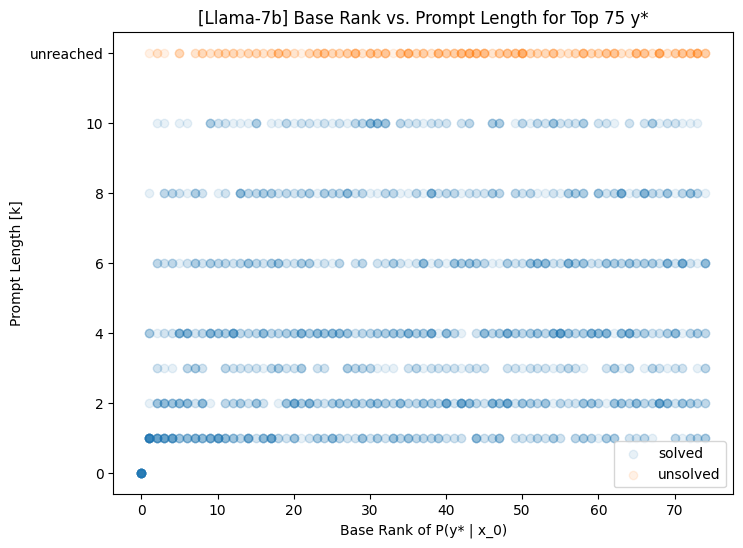

In [28]:
# base rank vs. prompt length 
title = '[Llama-7b] Base Rank vs. Prompt Length for Top 75 y*'
output_path = '../figures/shallow1_llama7b_base_rank_vs_prompt_length.pdf'
base_rank_k_scatter(ranked_shallow1_df, 
                    title=title, 
                    output_path=output_path, 
                    figsize=FIG_SIZE)

Pearson correlation coefficient: 0.5141300822947106
Saving figure...
Done


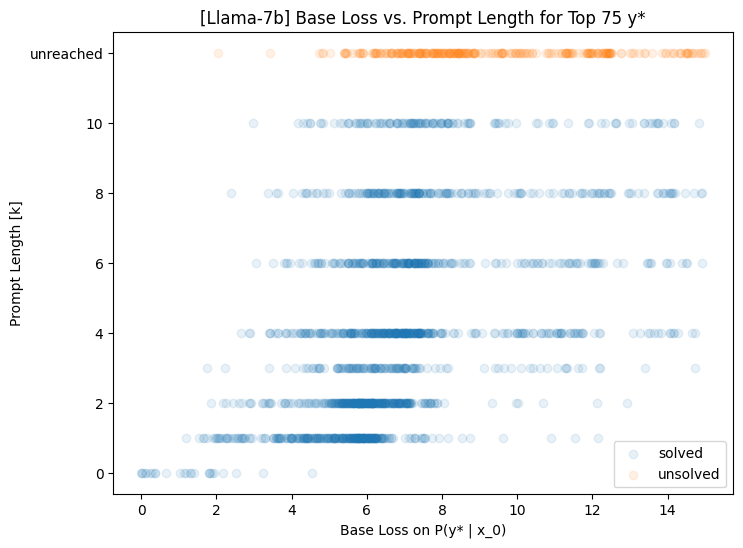

In [29]:
# Base loss vs. prompt length for llama-7b
title = '[Llama-7b] Base Loss vs. Prompt Length for Top 75 y*'
output_path = '../figures/shallow1_llama7b_base_loss_vs_prompt_length.pdf'
base_loss_vs_prompt_len(ranked_shallow1_df, 
                        title=title, 
                        output_path=output_path, 
                        figsize=FIG_SIZE)


Pearson correlation coefficient: 0.47619729209989675
Saving figure...
Done


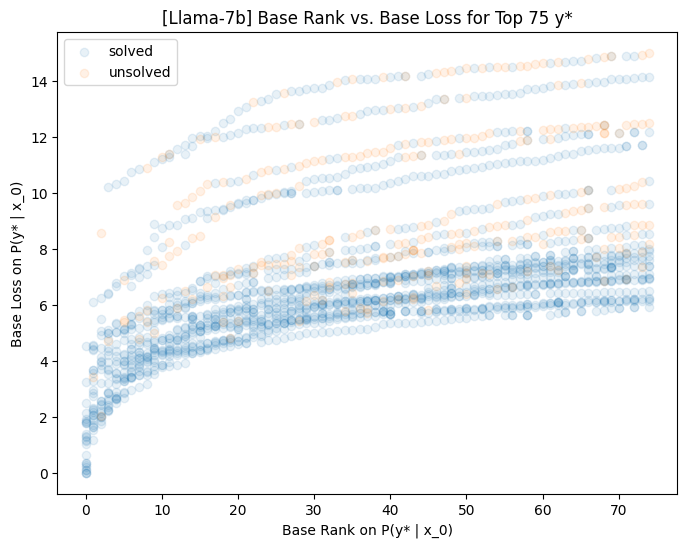

In [31]:
# Base rank vs. base loss for llama-7b
title = '[Llama-7b] Base Rank vs. Base Loss for Top 75 y*'
output_path = '../figures/shallow1_llama7b_base_rank_vs_base_loss.pdf'
base_rank_vs_base_loss(ranked_shallow1_df, 
                       title=title, 
                       output_path=output_path, 
                       figsize=FIG_SIZE)


## 3: Falcon-40b Top-75 Experiments

### 3.1: Load the Falcon-40b Data

In [33]:
file_path = f'falcon-40b/shallow1_*_of_*.csv'
file_list = glob.glob(file_path)
print(file_list)
df_list = []
for file in file_list:
    df_list.append(pd.read_csv(file, lineterminator='\n'))
shallow_df = pd.concat(df_list)

# overview 
overview_report(shallow_df)

['falcon-40b/shallow1_1_of_4.csv', 'falcon-40b/shallow1_3_of_4.csv', 'falcon-40b/shallow1_0_of_4.csv']
Length of dataframe:  281
Mean prompt correct (epsilon): 	 0.8469750889679716
Mean prompt correct with k <= 4:  0.5658362989323843
Mean base correct: 		 0.014234875444839857
Mean prompt length: 		 5.00355871886121


In [35]:
# Save the dataframe to a csv file
output_path = 'falcon-40b/shallow1.csv'
# check if it exists
if os.path.exists(output_path):
    print("File already exists")
else:
    print(f"Saving dive1 to {output_path}")
    shallow_df.to_csv(output_path, index=False, lineterminator='\n')

File already exists


Let's now create a version of the `dive1.csv` dataset with the logits and rankings 
for Falcon-40b: 

```bash
>>> python3 scripts/add_logits.py \
    --input_file results/shallow_dive/falcon-40b/shallow1.csv \
    --output_file results/shallow_dive/falcon-40b/ranked_shallow1.csv \
    --model falcon-40b
```

In [ ]:
# Load in the ranked shallow df
try:
    ranked_shallow1_df = pd.read_csv('falcon-40b/ranked_shallow1.csv', lineterminator='\n')
except:
    # throw error that the file does not exist
    print("File `falcon-40b/ranked_shallow1.csv` does not exist. Please run `add_logits.py` script.")

overview_report(ranked_shallow1_df)